In this project, we will explore how to implement image classification using machine learning. It demonstrates the implementation of Image Segmentation by using K-Mean Clustering. The dataset is available in kaggle https://www.kaggle.com/datasets/tongpython/cat-and-dog

# Gaussian Mixture Model (GMM) for Image Segmentation

## Introduction
The **Gaussian Mixture Model (GMM)** is a probabilistic model that represents a dataset as a combination of multiple Gaussian distributions. It is widely used in unsupervised learning tasks such as clustering and image segmentation.

In the context of image segmentation, GMM assumes that the pixel intensities (or other features like color values) in an image can be modeled as a mixture of K Gaussian distributions. Each Gaussian represents a distinct segment or class in the image.


## Key Concepts

### 1. Gaussian Distribution
The Gaussian distribution, also known as the normal distribution, is defined as:
$$
\mathcal{N}(x \mid \mu, \sigma^2) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{(x - \mu)^2}{2 \sigma^2}\right)
$$
where:
where:
- X: Data point.
- $ \mu $: Mean of the distribution.
- $\sigma^2$: Variance (spread) of the distribution.

### 2. Gaussian Mixture Model
A GMM models a dataset as a mixture of \( K \) Gaussian components, each with its own parameters:
$$
p(x) = \sum_{k=1}^{K} \pi_k \cdot \mathcal{N}(x \mid \mu_k, \Sigma_k)
$$
where:
- K: Number of Gaussian components.
- πₖ: Weight (mixing coefficient) of the k-th Gaussian, with ∑ₖ πₖ = 1.
- μₖ: Mean of the k-th Gaussian.
- Σₖ: Covariance matrix of the k-th Gaussian.


### 3. Expectation-Maximization (EM) Algorithm
The parameters of the GMM ($\pi_k, \mu_k, \Sigma_k$) are estimated using the EM algorithm, which iteratively maximizes the likelihood of the data. It involves two main steps:

1. **Expectation (E-step)**:
   Compute the responsibility $ r_{ik} $, the probability that data point $ x_i $ belongs to component $ k $:
   $$
   r_{ik} = \frac{\pi_k \cdot \mathcal{N}(x_i \mid \mu_k, \Sigma_k)}{\sum_{j=1}^K \pi_j \cdot \mathcal{N}(x_i \mid \mu_j, \Sigma_j)}
   $$

2. **Maximization (M-step)**:
   Update the parameters using the responsibilities:
   $$
   \pi_k = \frac{1}{N} \sum_{i=1}^N r_{ik}, \quad
   \mu_k = \frac{\sum_{i=1}^N r_{ik} x_i}{\sum_{i=1}^N r_{ik}}, \quad
   \Sigma_k = \frac{\sum_{i=1}^N r_{ik} (x_i - \mu_k)(x_i - \mu_k)^T}{\sum_{i=1}^N r_{ik}}
   $$
   where N is the total number of data points.



## Image Segmentation with GMM
- In image segmentation, each pixel or feature vector is treated as a data point \( x_i\).
- The goal is to assign each pixel to the Gaussian component (class) it most likely belongs to:
  $$
  \text{Segment}(x_i) = \arg\max_k \; r_{ik}
  $$

For example, in a grayscale image, the pixel intensities can be directly modeled by GMM. In color images, features like RGB values are used.



## Example Workflow
1. **Preprocessing**:
   - Reshape the image into a feature vector (e.g., pixel intensities, RGB values).
2. **Apply GMM**:
   - Use the EM algorithm to fit the GMM and classify pixels into K components.
3. **Segmented Image**:
   - Map the assigned classes back to the image dimensions.



## Applications
- **Medical Imaging**: Tissue classification in MRI or CT scans.
- **Remote Sensing**: Land cover classification in satellite images.
- **Object Detection**: Isolating regions of interest in images.



This notebook introduces the foundation of GMMs for image segmentation, providing the mathematical framework and its connection to practical applications.

**Import nessessary library**

In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

**Data Preprocessing**

In [2]:
# Function to preprocess images
def preprocess_image(image_path, target_size=(128, 128)):
    img = Image.open(image_path).convert('RGB')  # Convert to grayscale
    img = img.resize(target_size)             # Resize to target size
    img_array = np.array(img)                 # Convert to numpy array
    return img_array / 255.0        # Normalize and flatte

This function is designed for preprocessing an input image. It performs several key operations. First, the image is read into the program, and then it is resized to the desired dimensions. Next, the image is converted into a numpy array format, which is essential for numerical operations in Python. Finally, the values in the array are normalized to a range between 0 and 1, which is a common practice in image processing to ensure uniformity and better performance during analysis or training.

**Load Dataset**

In [3]:
def load_dataset(data_dir, categories, target_size=(128, 128), test_size=0.2, random_state=42):
    
    images, labels = [], []  # Initialize empty lists to store image data and labels
    valid_extensions = ('.png', '.jpg', '.jpeg')  # Define valid image file extensions

    for category in categories:
        category_dir = os.path.join(data_dir, category)  # Construct the path to the category directory
        for file_name in os.listdir(category_dir):
            # Skip hidden/system files or files with invalid extensions
            if file_name.startswith('.') or not file_name.lower().endswith(valid_extensions):
                continue
            
            file_path = os.path.join(category_dir, file_name)  # Construct the full path to the file
            try:
                # Preprocess the image
                img_array = preprocess_image(file_path, target_size)
                images.append(img_array)  # Add processed image to the list
                labels.append(category)  # Add category label
            except Exception as e:
                print(f"Error loading image {file_path}: {e}")

    # Convert lists to NumPy arrays
    images = np.array(images)
    labels = np.array(labels)
    
    # Split the dataset into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        images, labels, test_size=test_size, random_state=random_state, stratify=labels
    )
    
    return X_train, X_test, y_train, y_test

Loading a dataset is a crucial step in data preparation, particularly for deep learning tasks. In this case, the data consists of images, and its structure plays a significant role in the processing pipeline. The primary goal of this function is to transform raw images into a standardized format of [batch, width, height, channel], which aligns with the conventions used in PyTorch. By doing so, it enables batch training, a standard practice in most popular deep learning frameworks, ensuring efficiency and scalability during the training process.

In [4]:
# Note that the path will be different on your environment.

training_path = "./archive/training_set/training_set/"


categories = ['cats','dogs']

# Load and split the dataset
X_train, X_test, y_train, y_test = load_dataset(training_path, categories, target_size=(128, 128), test_size=0.2)

# Check the shapes of the resulting arrays
print("Training set:", X_train.shape, y_train.shape)
print("Testing set:", X_test.shape, y_test.shape)

Training set: (6404, 128, 128, 3) (6404,)
Testing set: (1601, 128, 128, 3) (1601,)


In [5]:
# Checking labels
y_train[4000]

'cats'

**Simple Visualization**

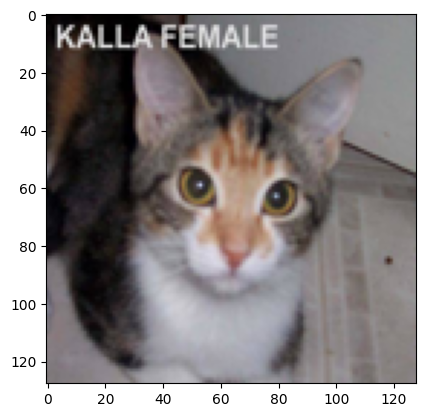

In [6]:
img_ex = X_train[4000,:,:,:] # Select the 4000th image to visualize
plt.imshow(img_ex)
plt.show()

pixels shape : (1638400, 3)


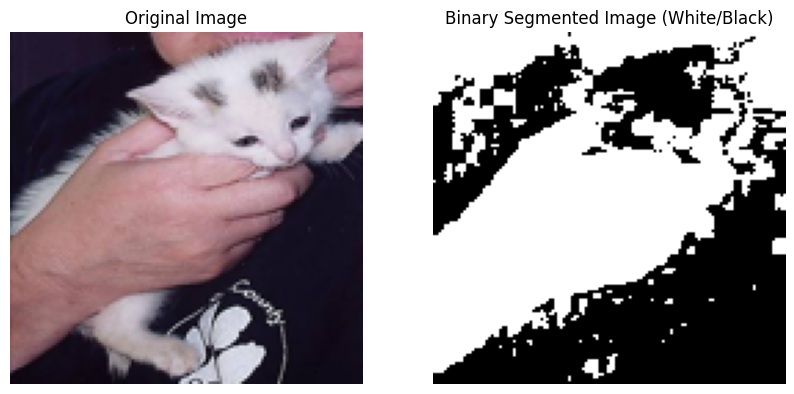

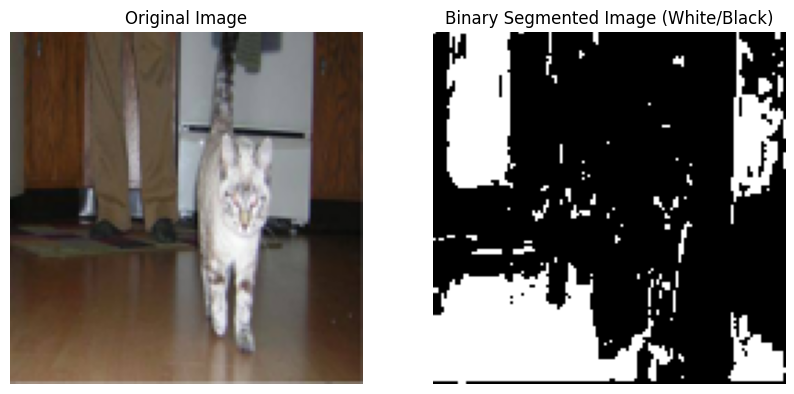

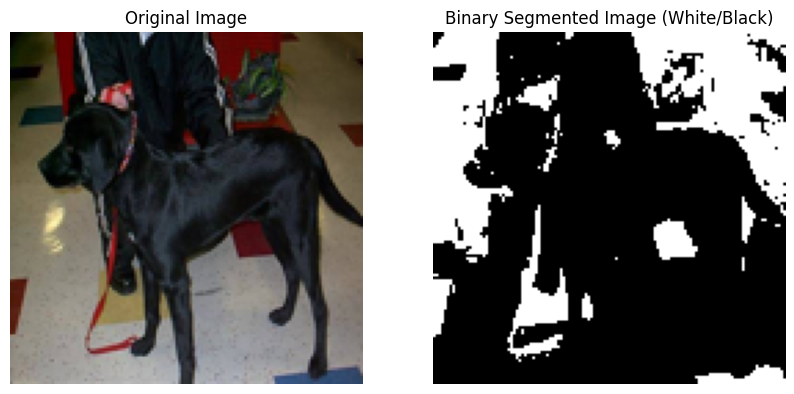

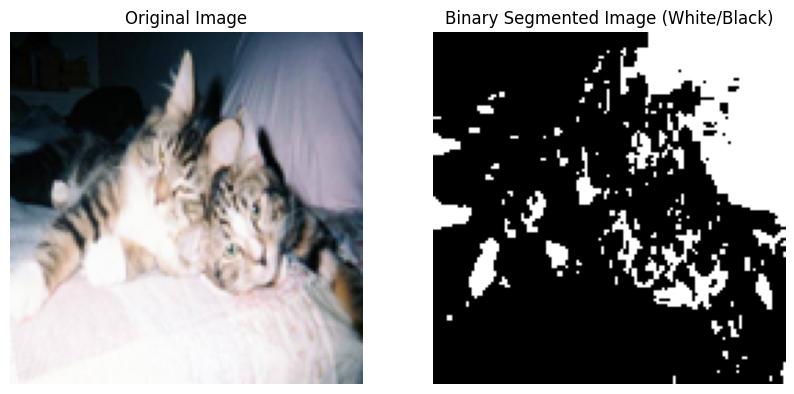

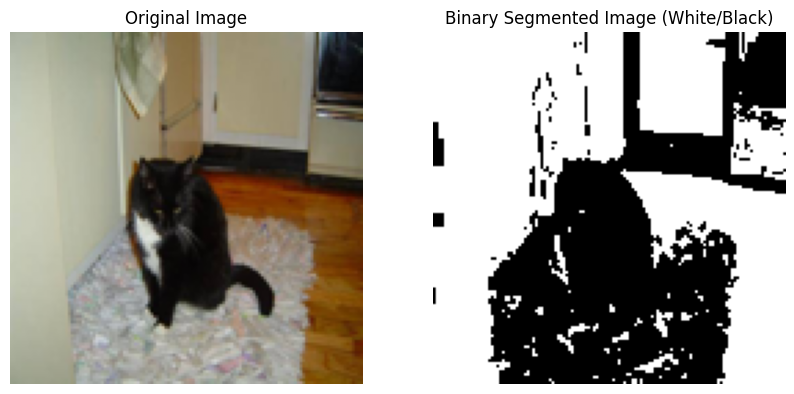

In [9]:
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


X_example = X_train[:100]

def gmm_binary_segmentation(images, n_clusters=2, max_iter=70):
    """Perform binary segmentation (white/black) using GMM for a dataset of images."""
    n_samples, rows, cols, channels = images.shape
    pixels = images.reshape((-1, channels))  # Flatten all images into (total_pixels, num_features)
    
    print(f'pixels shape : {pixels.shape}')

    # Fit Gaussian Mixture Model
    gmm = GaussianMixture(n_components=n_clusters, max_iter=max_iter, random_state=42)
    gmm.fit(pixels)

    # Predict cluster labels
    labels = gmm.predict(pixels)

    # Determine which cluster corresponds to black or white
    cluster_means = gmm.means_.mean(axis=1)  # Mean intensity per cluster
    foreground_label = np.argmax(cluster_means)  # The brighter cluster (higher mean) is foreground

    # Map labels to binary intensity values
    binary_pixels = np.where(labels == foreground_label, 255, 0).astype(np.uint8)
    binary_images = binary_pixels.reshape((n_samples, rows, cols))
    return binary_images

# Perform binary segmentation on the dataset
binary_segmented_images = gmm_binary_segmentation(X_example)

# Display original and binary segmented images for the first few samples
for i in range(min(5, len(X_train))):  # Display up to 5 images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(X_train[i])
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Binary Segmented Image (White/Black)")
    plt.imshow(binary_segmented_images[i], cmap="gray")
    plt.axis("off")
    plt.show()

The provided code defines a function gmm_segmentation_dataset that performs Gaussian Mixture Model (GMM) clustering for a dataset of images. The function takes an array of images, the number of clusters (n_clusters), and a maximum number of iterations (max_iter). Each image in the dataset is flattened into a list of pixel features, combining all images into a single dataset of pixel values. The GMM algorithm initializes Gaussian components and iteratively refines their parameters using the Expectation-Maximization (EM) algorithm. In each iteration, pixels are probabilistically assigned to clusters based on the likelihood of belonging to a Gaussian distribution, and the model updates the parameters of each Gaussian (mean, variance, and mixing weights). The algorithm stops once convergence is achieved or the maximum number of iterations is reached. After clustering, the function reconstructs the segmented images by assigning each pixel to the mean of its corresponding Gaussian component. The result is a set of images segmented into the specified number of clusters, which is useful for image segmentation tasks. In the example usage, the function is called with n_clusters=2 to segment the dataset X_train into two clusters, achieving binary segmentation.